# Prepare

In [2]:
!pip install scikit-learn==1.0.2
!pip install scikit-survival

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 43.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.13.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 791.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 69.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [17]:


import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal


data = pd.read_excel('4A_TB_cleaned.xlsx')



# data = pd.concat([data] * 4, ignore_index=True)

# Converting duration to whole weeks (assuming 7 days per week)
# data['Duration (weeks)'] = data['DURATION'].apply(lambda x: int(x // 7 + (x % 7 > 0)))
# data['WEEK'] = [1, 2, 3, 4] * (len(data) // 4)

data.head()

# function to calculate the survival status
def calculate_survival_status(row):
    if row['OUT COME'] == 'DIED':
        return 1
    else:
        return 0


data['SURVIVAL'] = data.apply(calculate_survival_status, axis=1)

data.drop(columns=['UNIT','DISTRICT OF RESIDENCE','WORKING DIAGNOSIS','ADDITIONAL WORKING DIAGNOSIS',
                   'MARITAL STATUS', 'IP NUMBER', 'OUT COME'], inplace=True)

new_col_order = ['SEX', 'AGE', 'RELIGION', 'REGION', 'NUMBER OF ADDITIONAL WORKING DIAGNOSIS', 'TB_type',
                 'NUMBER OF PREVIOUS ADMISSIONS', 'DAY OF ADMISSION', 'MONTH OF ADMISSION',
                 'YEAR OF ADMISSION', 'DURATION', 'SURVIVAL']
data = data[new_col_order]

data.dropna(subset=['SURVIVAL'], inplace=True)
data.reset_index(drop=True, inplace=True)
data['SURVIVAL'] = data['SURVIVAL'].astype(int)

data.shape

(16368, 12)

In [18]:
data.head()

,SEX,AGE,RELIGION,REGION,NUMBER OF ADDITIONAL WORKING DIAGNOSIS,TB_type,NUMBER OF PREVIOUS ADMISSIONS,DAY OF ADMISSION,MONTH OF ADMISSION,YEAR OF ADMISSION,DURATION,SURVIVAL
0,M,30,COU,CENTRAL,1,Abdominal_TB,5,Tuesday,November,2010,6,0
1,M,30,COU,CENTRAL,1,Abdominal_TB,5,Tuesday,November,2010,6,0
2,M,30,COU,CENTRAL,1,Abdominal_TB,5,Tuesday,November,2010,6,0
3,M,30,COU,CENTRAL,1,Abdominal_TB,5,Tuesday,November,2010,6,0
4,F,46,COU,CENTRAL,1,Disseminated TB,3,Monday,December,2010,4,0


In [19]:


# dictionary for month encoding
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
                 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

# dictionary for day of week encoding
day_mapping = {'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday':76 }

data['Month of Admission'] = data['MONTH OF ADMISSION'].map(month_mapping)
data['Day of Admission'] = data['DAY OF ADMISSION'].map(day_mapping)

data.drop(columns=['MONTH OF ADMISSION', 'DAY OF ADMISSION'], inplace=True)



categorical_features = ['SEX', 'RELIGION', 'REGION', 'TB_type']

df = pd.get_dummies(data, columns=categorical_features)
df = df.astype(int)
df.head()

#Standardizing continuous features
standardize_features = ['AGE','NUMBER OF PREVIOUS ADMISSIONS','NUMBER OF ADDITIONAL WORKING DIAGNOSIS', 'DURATION', 'Month of Admission', 'Day of Admission']
scaler = StandardScaler()
df[standardize_features] = scaler.fit_transform(df[standardize_features])
df.head()

,AGE,NUMBER OF ADDITIONAL WORKING DIAGNOSIS,NUMBER OF PREVIOUS ADMISSIONS,YEAR OF ADMISSION,DURATION,SURVIVAL,Month of Admission,Day of Admission,SEX_F,SEX_M,...,REGION_EASTERN,REGION_NORTHERN,REGION_UNKNOWN,REGION_WESTERN,TB_type_Abdominal_TB,TB_type_CNS_TB,TB_type_Disseminated TB,TB_type_Other TBs,TB_type_PTB,TB_type_TB iris
0,-0.476431,-0.700413,0.829420,2010,-0.302662,0,1.335036,-0.368800,0,1,...,0,0,0,0,1,0,0,0,0,0
1,-0.476431,-0.700413,0.829420,2010,-0.302662,0,1.335036,-0.368800,0,1,...,0,0,0,0,1,0,0,0,0,0
2,-0.476431,-0.700413,0.829420,2010,-0.302662,0,1.335036,-0.368800,0,1,...,0,0,0,0,1,0,0,0,0,0
3,-0.476431,-0.700413,0.829420,2010,-0.302662,0,1.335036,-0.368800,0,1,...,0,0,0,0,1,0,0,0,0,0
4,1.010431,-0.700413,0.353972,2010,-0.559238,0,1.626162,-0.413998,1,0,...,0,0,0,0,0,0,1,0,0,0


In [20]:

df['SURVIVAL'].value_counts()


,count
SURVIVAL,
0,11124
1,5244


In [21]:
from sklearn.utils import resample

# Combine the majority and minority class data
data_majority = df[df['SURVIVAL'] == 0]
data_minority = df[df['SURVIVAL'] == 1]

# Oversample minority class
data_minority_upsampled = resample(data_minority,
                                   replace=True,     # sample with replacement
                                   n_samples=len(data_majority),    # to match majority class
                                   random_state=123) # reproducible results

# Combine majority class with upsampled minority class
dataset = pd.concat([data_majority, data_minority_upsampled])

# Display new class counts
print(dataset['SURVIVAL'].value_counts())


SURVIVAL
0    11124
1    11124
Name: count, dtype: int64


In [22]:
# **data splitting**

dataset['YEAR OF ADMISSION'].value_counts()



# prompt: create two data frames one for testing and the other for training and validation. dataset is split into these two using the 'YEAR OF ADMISSION' column.2018 and above go  to test dataset, 2017 and 2016 go validation dataset. then below 2016 goes to training dataset. use the copy method because i will have to standardize. Lets add the part of dropping that column from our data frames

test_data = dataset[dataset['YEAR OF ADMISSION'] >= 2018].copy()
train_data = dataset[dataset['YEAR OF ADMISSION'] < 2018].copy()

test_data.drop(columns=['YEAR OF ADMISSION'], inplace=True)
train_data.drop(columns=['YEAR OF ADMISSION'], inplace=True)
dataset.drop(columns=['YEAR OF ADMISSION'], inplace=True)


def to_tf_dataset(data, features, target, task_col, batch_size=64):
    def generator():
        for _, row in data.iterrows():
            x = row[features].values.astype(np.float32)
            y = row[target].astype(np.float32)
            task = row[task_col].astype(np.int32) - 1
            yield x, y, task

    output_signature = (
        tf.TensorSpec(shape=(len(features),), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature).batch(batch_size).shuffle(buffer_size=1024)

X = [col for col in dataset.columns if col not in ['SURVIVAL', 'WEEK', 'DURATION']]
E = 'SURVIVAL'
T = 'DURATION'

train_dataset = to_tf_dataset(train_data, X, E, T)
test_dataset = to_tf_dataset(test_data, X, E, T)

In [23]:
train_data.shape

(17857, 25)

# train 1

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

class BaseMultiTaskModel:
    def __init__(self, structure, bins=100, auto_scaler=True):
        self.structure = structure
        self.bins = bins
        self.auto_scaler = auto_scaler
        self.scaler = StandardScaler() if auto_scaler else None
        self.model = None
        self.loss_values = []

    def get_times(self, T, is_min_time_zero=True, extra_pct_time=0.1):
        max_time = np.max(T)
        min_time = 0. if is_min_time_zero else np.min(T)
        p = extra_pct_time if 0. <= extra_pct_time <= 1. else 0.1

        self.times = np.linspace(min_time, max_time * (1. + p), self.bins)
        self.time_buckets = [(self.times[i], self.times[i + 1]) for i in range(len(self.times) - 1)]
        self.num_times = len(self.time_buckets)

    def compute_XY(self, X, T, E, is_min_time_zero, extra_pct_time):
        self.get_times(T, is_min_time_zero, extra_pct_time)
        n_units = T.shape[0]

        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []

        for i, (t, e) in enumerate(zip(T, E)):
            y = np.zeros(self.num_times + 1)
            min_abs_value = [abs(a_j_1 - t) for (a_j_1, a_j) in self.time_buckets]
            index = np.argmin(min_abs_value)

            if e == 1:
                y[index] = 1.
                X_uncens.append(X[i, :].tolist())
                Y_uncens.append(y.tolist())
            else:
                y[index:] = 1.
                X_cens.append(X[i, :].tolist())
                Y_cens.append(y.tolist())

        return np.array(X_cens), np.array(X_uncens), np.array(Y_cens), np.array(Y_uncens)

    def build_model(self, input_shape):
        inputs = Input(shape=(input_shape,))
        x = inputs
        for layer in self.structure:
            x = Dense(units=layer['num_units'], activation=layer['activation'])(x)
        outputs = Dense(self.num_times + 1, activation='linear')(x)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=1e-6, clipnorm=1.0), loss=self.loss_function)
        return model

    def loss_function(self, y_true, y_pred):
        # Adjust Triangle shape to match y_pred
        Triangle = np.tri(self.num_times + 1, self.num_times + 1, dtype=np.float32)
        Triangle = tf.convert_to_tensor(Triangle, dtype=tf.float32)

        phi_uncens = tf.exp(tf.linalg.matmul(y_pred, Triangle))

        reduc_phi_uncens = tf.reduce_sum(phi_uncens * y_true, axis=1)

        z_uncens = tf.exp(tf.linalg.matmul(y_pred, Triangle))
        reduc_z_uncens = tf.reduce_sum(z_uncens, axis=1)

        loss = -tf.reduce_sum(tf.math.log(reduc_phi_uncens)) + tf.reduce_sum(tf.math.log(reduc_z_uncens))
        return loss

    def fit(self, X, T, E, epochs=1000, batch_size=32, verbose=True):
        X, T, E = np.array(X), np.array(T), np.array(E)
        self.num_vars = X.shape[1]

        if self.auto_scaler:
            X = self.scaler.fit_transform(X)

        X_cens, X_uncens, Y_cens, Y_uncens = self.compute_XY(X, T, E, True, 0.1)

        self.model = self.build_model(self.num_vars)

        X_train = np.concatenate((X_cens, X_uncens), axis=0)
        Y_train = np.concatenate((Y_cens, Y_uncens), axis=0)

        early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
        self.model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[early_stopping])

    def predict(self, x):
        if self.auto_scaler:
            x = self.scaler.transform(x)

        x = np.array(x)
        score = self.model.predict(x)

        Triangle1 = np.tri(self.num_times + 1, self.num_times + 1) # Fix: Adjust Triangle1 shape
        Triangle2 = np.tri(self.num_times + 1, self.num_times + 1)

        phi = np.exp(np.dot(score, Triangle1))
        div = np.repeat(np.sum(phi, 1).reshape(-1, 1), phi.shape[1], axis=1)
        density = phi / div
        Survival = np.dot(density, Triangle2)
        hazard = density[:, :-1] / Survival[:, 1:]

        return hazard, density, Survival

    def predict_risk(self, x, use_log=False):
        _, _, Survival = self.predict(x)
        risk = 1 - Survival[:, -1]
        return np.log(risk) if use_log else risk


# Example usage
structure = [{'activation': 'relu', 'num_units': 128}]
model = BaseMultiTaskModel(structure=structure, bins=100)


X_data = dataset[X].values
T_data = dataset[T].values
E_data = dataset[E].values

# Fit the model
model.fit(X_data, T_data, E_data, epochs=100, verbose=True)
hazard, density, Survival = model.predict(X_data[:5])
print(hazard, density, Survival)


Epoch 1/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 110.8605
Epoch 2/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 83.3100
Epoch 3/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 61.5139
Epoch 4/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 47.8118
Epoch 5/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 39.5568
Epoch 6/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 35.0787
Epoch 7/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 32.5627
Epoch 8/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 30.9572
Epoch 9/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 29.5951
Epoch 10/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 28.4321
Epoch 11/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 27.5782
Epoch 12/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 27.0328
Epoch 13/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 26.5624
Epoch 14/100
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 26.1443


KeyboardInterrupt: 

# train5

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal

class BaseMultiTaskModel:
    def __init__(self, structure, bins=100, auto_scaler=True, dropout_rate=0.5, l2_lambda=0.01, initializer='glorot_uniform'):
        self.structure = structure
        self.bins = bins
        self.auto_scaler = auto_scaler
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.scaler = StandardScaler() if auto_scaler else None
        self.model = None
        self.loss_values = []
        self.val_loss_values = []
        self.initializer = initializer

    def get_initializer(self):
        if self.initializer == 'glorot_uniform':
            return GlorotUniform()
        elif self.initializer == 'glorot_normal':
            return GlorotNormal()
        else:
            raise ValueError("Initializer not supported. Choose either 'glorot_uniform' or 'glorot_normal'.")

    def get_times(self, T, is_min_time_zero=True, extra_pct_time=0.1):
        max_time = np.max(T)
        min_time = 0. if is_min_time_zero else np.min(T)
        p = extra_pct_time if 0. <= extra_pct_time <= 1. else 0.1

        self.times = np.linspace(min_time, max_time * (1. + p), self.bins)
        self.time_buckets = [(self.times[i], self.times[i + 1]) for i in range(len(self.times) - 1)]
        self.num_times = len(self.time_buckets)

    def compute_XY(self, X, T, E, is_min_time_zero, extra_pct_time):
        self.get_times(T, is_min_time_zero, extra_pct_time)
        n_units = T.shape[0]

        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []

        for i, (t, e) in enumerate(zip(T, E)):
            y = np.zeros(self.num_times + 1)
            min_abs_value = [abs(a_j_1 - t) for (a_j_1, a_j) in self.time_buckets]
            index = np.argmin(min_abs_value)

            if e == 1:
                y[index] = 1.
                X_uncens.append(X[i, :].tolist())
                Y_uncens.append(y.tolist())
            else:
                y[index:] = 1.
                X_cens.append(X[i, :].tolist())
                Y_cens.append(y.tolist())

        return np.array(X_cens), np.array(X_uncens), np.array(Y_cens), np.array(Y_uncens)

    def build_model(self, input_shape):
        initializer = self.get_initializer()

        inputs = Input(shape=(input_shape,))
        x = inputs
        for layer in self.structure:
            x = Dense(units=layer['num_units'], activation=layer['activation'],
                      kernel_regularizer=l2(self.l2_lambda),
                      kernel_initializer=initializer)(x)
            x = Dropout(self.dropout_rate)(x)
        outputs = Dense(self.num_times + 1, activation='sigmoid', kernel_initializer=initializer)(x)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss=self.loss_function)
        return model

    def loss_function(self, y_true, y_pred):
        Triangle = np.tri(self.num_times + 1, self.num_times + 1, dtype=np.float32)
        Triangle = tf.convert_to_tensor(Triangle, dtype=tf.float32)

        phi_uncens = tf.exp(tf.linalg.matmul(y_pred, Triangle))

        reduc_phi_uncens = tf.reduce_sum(phi_uncens * y_true, axis=1)

        z_uncens = tf.exp(tf.linalg.matmul(y_pred, Triangle))
        reduc_z_uncens = tf.reduce_sum(z_uncens, axis=1)

        loss = -tf.reduce_sum(tf.math.log(reduc_phi_uncens)) + tf.reduce_sum(tf.math.log(reduc_z_uncens))
        return loss

    def fit(self, X, T, E, epochs=1000, batch_size=16, validation_split=0.2, verbose=True):
        X, T, E = np.array(X), np.array(T), np.array(E)
        self.num_vars = X.shape[1]

        if self.auto_scaler:
            X = self.scaler.fit_transform(X)

        X_cens, X_uncens, Y_cens, Y_uncens = self.compute_XY(X, T, E, True, 0.1)

        self.model = self.build_model(self.num_vars)

        X_train = np.concatenate((X_cens, X_uncens), axis=0)
        Y_train = np.concatenate((Y_cens, Y_uncens), axis=0)

        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=validation_split, random_state=42)

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = self.model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[early_stopping])

        self.loss_values = history.history['loss']
        self.val_loss_values = history.history['val_loss']

    def predict(self, x):
        if self.auto_scaler:
            x = self.scaler.transform(x)

        x = np.array(x)
        score = self.model.predict(x)

        Triangle1 = np.tri(self.num_times + 1, self.num_times + 1)
        Triangle2 = np.tri(self.num_times + 1, self.num_times + 1)

        phi = np.exp(np.dot(score, Triangle1))
        div = np.repeat(np.sum(phi, 1).reshape(-1, 1), phi.shape[1], axis=1)
        density = phi / div
        Survival = np.dot(density, Triangle2)
        hazard = density[:, :-1] / Survival[:, 1:]

        return hazard, density, Survival

    def predict_risk(self, x, use_log=False):
        _, _, Survival = self.predict(x)
        risk = 1 - Survival[:, -1]
        return np.log(risk) if use_log else risk

    def plot_loss_curve(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_values, label='Training Loss', color='blue')
        plt.plot(self.val_loss_values, label='Validation Loss', color='red')
        plt.title('Loss Function Values')
        plt.xlabel('Number of epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def evaluate(self, X, T, E):
        X, T, E = np.array(X), np.array(T), np.array(E)
        if self.auto_scaler:
            X = self.scaler.transform(X)

        _, _, Survival = self.predict(X)

        events = Surv.from_arrays(E == 1, T)
        c_index = concordance_index_censored(E, T, -Survival[:, -1])[0]

        # Calculate the Brier score
        time_grid = np.linspace(0, T.max(), 100)
        brier_scores = []
        for t in time_grid:
            pred_risk = np.mean(Survival[:, :-1] >= t, axis=1)
            brier_score = np.mean((E - pred_risk) ** 2)
            brier_scores.append(brier_score)
        integrated_brier_score = np.trapz(brier_scores, time_grid) / T.max()

        self.plot_brier_score(time_grid, brier_scores, integrated_brier_score)
        self.plot_actual_vs_predicted(T, E, Survival)

        return c_index, integrated_brier_score

    def plot_brier_score(self, time_grid, brier_scores, integrated_brier_score):
        plt.figure(figsize=(10, 6))
        plt.plot(time_grid, brier_scores, label=f'IBS: {integrated_brier_score:.2f}', color='blue')
        plt.axhline(y=0.25, color='red', linestyle='--', label='0.25 limit')
        plt.title('Prediction Error Curve with Integrated Brier Score')
        plt.xlabel('Time')
        plt.ylabel('Brier Score')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_actual_vs_predicted(self, T, E, Survival):
        time_grid = np.linspace(0, T.max(), 100)
        actual_events = np.array([(T >= t).sum() for t in time_grid])
        predicted_events = np.array([(Survival[:, :-1] >= t).sum() for t in time_grid])

        plt.figure(figsize=(10, 6))
        plt.plot(time_grid, actual_events, label='Actual', color='red')
        plt.plot(time_grid, predicted_events, label='Predicted', color='blue')
        plt.fill_between(time_grid, predicted_events - 1.96 * np.sqrt(predicted_events),
                         predicted_events + 1.96 * np.sqrt(predicted_events), color='blue', alpha=0.2,
                         label='Confidence Intervals')
        plt.title('Actual vs Predicted Number of Events Over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Events')
        plt.legend()
        plt.grid(True)
        plt.show()



In [29]:
# Data preparation code remains the same
# Example usage
structure = [{'activation': 'relu', 'num_units': 64}]
model = BaseMultiTaskModel(structure=structure, bins=100)

# Fit the model
model.fit(train_data[X], train_data[T], train_data[E], epochs=1000, batch_size=32, verbose=True, validation_split=0.2)




Epoch 1/1000
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 48.8492 - val_loss: 45.2256
Epoch 2/1000
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 44.3007 - val_loss: 41.3234
Epoch 3/1000
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 41.3563 - val_loss: 38.6916
Epoch 4/1000
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 37.3475 - val_loss: 37.0055
Epoch 5/1000
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 37.5161 - val_loss: 35.9720
Epoch 6/1000
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 36.4380 - val_loss: 35.2733
Epoch 7/1000
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 35.3602 - val_loss: 34.7970
Epoch 8/1000
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 35.0025 - val_loss: 34.4472
Epoch 9/1000
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 34.5051 - val_loss: 34.1807
Epoch 10/1000
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 34.6353 - val_loss: 33.9869
Epoch 11/1000
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 33.9875 - val_loss: 33.8208
Epoch 12

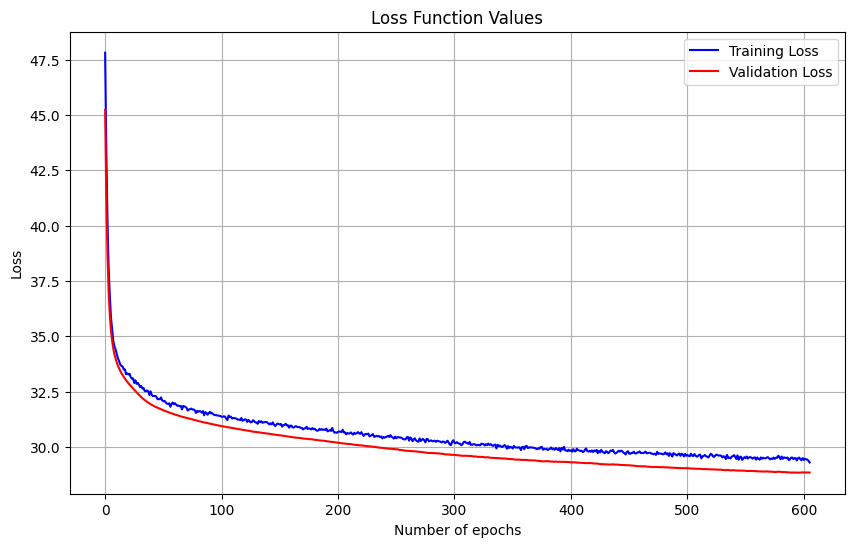

In [30]:
# Plot the loss curve
model.plot_loss_curve()

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


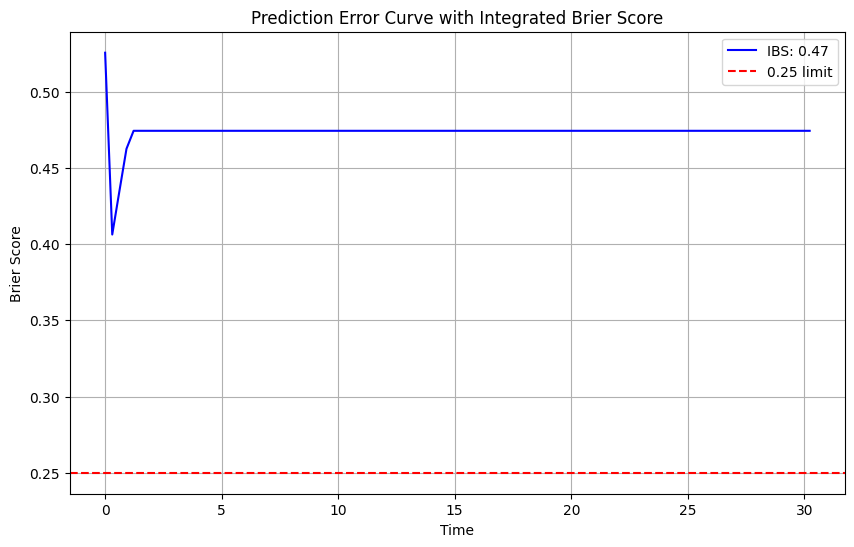

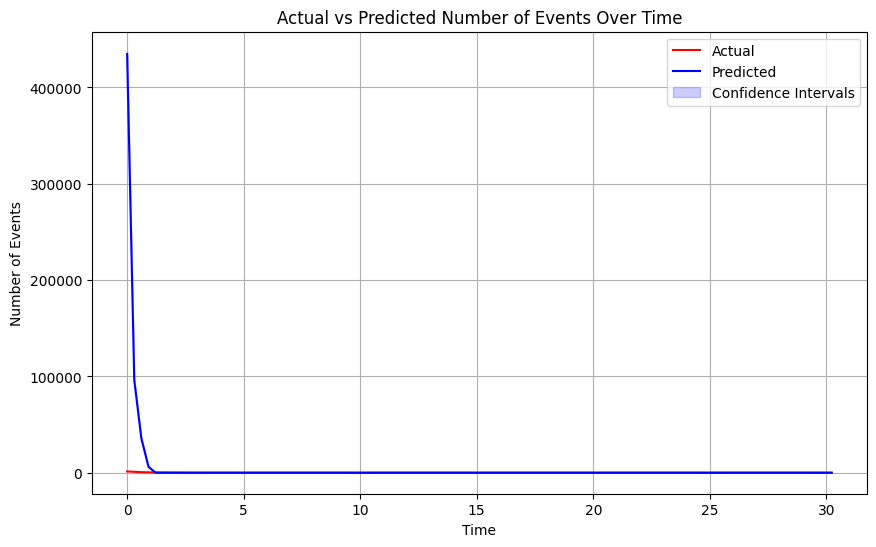

c-index: 0.5666537493708097, Brier score: 0.47342993683778106


In [31]:
# Evaluate the model
c_index, brier_score = model.evaluate(test_data[X], test_data[T], test_data['SURVIVAL'] == 1) # Access the 'SURVIVAL' column and create a boolean array
print(f"c-index: {c_index}, Brier score: {brier_score}")

In [10]:
# Make predictions (example)
hazard, density, Survival = model.predict(test_data[X].values[:5])
print(hazard)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[0.24087866 0.0972304  0.03825513 0.03799875 0.03648034 0.03744497
  0.03864868 0.03224285 0.03300311 0.02798653 0.02866563 0.02944968
  0.0301129  0.03055988 0.03083976 0.03103477 0.03121768 0.02749432
  0.0265932  0.02601352 0.02668523 0.026073   0.02659161 0.02597931
  0.02662416 0.02419037 0.02303722 0.02005441 0.02038929 0.02076948
  0.02119733 0.02159729 0.02203084 0.02150768 0.02196833 0.0219338
  0.02241155 0.02258844 0.02301059 0.02310043 0.02356041 0.02408969
  0.02444436 0.02497463 0.02560005 0.02625452 0.02689704 0.02762912
  0.02828146 0.02823059 0.02890974 0.02917349 0.02996204 0.0306655
  0.0315136  0.03119025 0.03000733 0.03093345 0.03109234 0.03202061
  0.03307704 0.03304167 0.03416915 0.03528125 0.03567633 0.03689988
  0.03811702 0.0396162  0.0411179  0.04283209 0.04474353 0.04682233
  0.04911281 0.05164698 0.05444936 0.05743509 0.06093085 0.06487878
  0.06937729 0.07453181 0.08052718 0.07216198 0.07582248 0.08195339
  0.08855905

In [11]:
print(density)

[[0.19411943 0.07141262 0.02706191 0.02589651 0.02398666 0.02373227
  0.02358369 0.01906026 0.01888637 0.01557956 0.01551291 0.0154813
  0.0153672  0.01513284 0.01481455 0.01445949 0.0141044  0.01208976
  0.0113906  0.01085981 0.01085067 0.01033234 0.01026489 0.0097746
  0.00975743 0.00865609 0.00805782 0.00687661 0.00685173 0.00683748
  0.00683348 0.00681523 0.00680218 0.00650084 0.00649733 0.00634789
  0.00634398 0.00625281 0.00622639 0.00610957 0.00608779 0.00607813
  0.00602045 0.00600118 0.00599791 0.00599389 0.00597973 0.00597734
  0.00595019 0.00577642 0.00574917 0.00563717 0.00562112 0.00558192
  0.00556105 0.00533751 0.00498548 0.00498514 0.00485965 0.00484945
  0.00484905 0.00468894 0.00468873 0.00467634 0.00456582 0.00455435
  0.00453184 0.00453059 0.00451662 0.00451167 0.00451116 0.0045096
  0.00450877 0.00450856 0.00450775 0.00449667 0.00449639 0.00449603
  0.00449586 0.00449488 0.00449452 0.00375654 0.00366891 0.0036652
  0.00363841 0.00307174 0.00304881 0.00303763 0.0029

In [12]:
print(Survival)

[[1.00000000e+00 8.05880571e-01 7.34467956e-01 7.07406048e-01
  6.81509536e-01 6.57522877e-01 6.33790606e-01 6.10206915e-01
  5.91146660e-01 5.72260292e-01 5.56680730e-01 5.41167816e-01
  5.25686517e-01 5.10319320e-01 4.95186480e-01 4.80371926e-01
  4.65912441e-01 4.51808043e-01 4.39718287e-01 4.28327682e-01
  4.17467872e-01 4.06617199e-01 3.96284864e-01 3.86019970e-01
  3.76245373e-01 3.66487939e-01 3.57831852e-01 3.49774031e-01
  3.42897425e-01 3.36045691e-01 3.29208207e-01 3.22374723e-01
  3.15559493e-01 3.08757312e-01 3.02256476e-01 2.95759142e-01
  2.89411252e-01 2.83067275e-01 2.76814469e-01 2.70588076e-01
  2.64478510e-01 2.58390718e-01 2.52312585e-01 2.46292133e-01
  2.40290954e-01 2.34293040e-01 2.28299154e-01 2.22319421e-01
  2.16342080e-01 2.10391891e-01 2.04615474e-01 1.98866302e-01
  1.93229133e-01 1.87608014e-01 1.82026093e-01 1.76465043e-01
  1.71127532e-01 1.66142054e-01 1.61156915e-01 1.56297268e-01
  1.51447815e-01 1.46598762e-01 1.41909824e-01 1.37221097e-01
  1.3254